# Project 2

## Can you hear the size of a reservoir?


## Group 1 9:

- Mussa Banjai
- Tapas Dev
- Jason Kapka
- Taz Ahmed

## Introduction

 A well test is a set of procedures, performed under specified conditions, to measure the factors affecting the capability of a well for production[1]. It is helpful to find the size of the large reservoirs and also investigates the end boundaries of the reservoirs. Well testing provides the estimate of permeability under any condition and also provides the near-wellbore condition. It plays a central role in oil and gas industries.  

 The diffusivity equation is used to solve the flow problems in porous media [2]. To obtain a solution to the radial flow diffusivity equation, it is necessary to specify an initial condition so we imposed two boundary conditions (Lazy and Not so Lazy) in this project. The initial condition simply states that the reservoir is at a uniform pressure pi when production begins [1]. Finally evaluated the reservoir behaviour from well and reservoir pressures and its dependence on time.  To monitor changes in reservoir permeability, a key tool is well pressure testing.[3]

 Sparse, Dense and Thomas matrix solvers are used to find the numerical solution, each of them have different properties and efficiencies. Compared these matrix solvers to gain insight on their time efficiences. Matching the simulated results with the provided well data shows that pressure decreases and becomes constant at the end giving a signal that the pressure wave has reached at the end of the reservoir.

## Abstract

This project is focused on finding information on reservoir performance and well productivity by using reservoir pressures. The project starts with theory to motivate and provide
background for understanding the physics of fluid flow. We needed to implement Taylor’s formula into numerical solvers for the radial diffusivity equation. In exercise 1, both theoretically and using Python, numerical solutions and analytical were evaluated at steady state using lazy method and not so lazy methods. Then in the next exercise, firstly we introduced a time factor to the diffusivity equation and then again once more evaluated the reservoir pressures using an implicit technique to capture how pressure varies over time. In the next exercise, we evaluated pressure decline in a well using the time-dependent model, and use the well test data to estimate the size of the reservoir. We introduced three different kinds matrix solvers (Dense, Sparse, and Thomas algorithm) and compare the numerical solver implementation with the line-source solution. In the last exercise, we matched well test data from the provided file with our estimations that we created through simulation. To manually match our numerical model to the well test data we modified initial pressure and permeability values. For time dependence solution, as we increases the time, the difference between line-sourse solution and numerical solution gets larger and vise versa. The sparse and dense method both gave a very small numerical error. Furthermore, we plotted the experimental well test data, numerical well pressure solution and corresponding line source solution. In conclusion, we were able to avoid reservoir compaction by observing how well and reservoir performance change over time.

## Libraries

In [1]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import math as m
import scipy as sp
from scipy import optimize
import pandas as pd

## Pressure Solver class

In [2]:
class PressureSolver:
    """
    A finite difference solver to solve pressure distribution in 
    a reservoir, logarithmic grid has been used, y = ln(r/rw) 

    The solver uses SI units internally, while "practical field units"
    are required as input.

    Input arguments:

        name                                symbol      unit
        --------------------------------------------------------------
        Number of grid points                N          dimensionless
        Constant time step                   dt         days
        Well radius                          rw         ft
        Outer reservoir boundary             re         ft
        Height of reservoir                  h          ft
        Absolute permeability                k          mD
        Porosity                             phi        dimensionless
        Fluid viscosity                      mu         mPas (cP)
        Total (rock+fluid) compressibility   ct         1 / psi
        Constant flow rate at well           Q          bbl / day
        Initial reservoir pressure           pi         psi
        -------------------------------------------------------------
    """

    def __init__(self,
                 N,
                 dt,
                 T,
                 rw=0.318,
                 re=1000.0,
                 h=11.0,
                 phi=0.25,
                 mu=1.0,
                 ct=7.8e-6,
                 Q=1000.0,
                 k=500,
                 pi=4100.0,
                 ):

        # Unit conversion factors (input units --> SI)
        self.ft_to_m = 0.3048
        self.psi_to_pa = 6894.75729
        self.day_to_sec = 24.*60.*60.
        self.bbl_to_m3 = 0.1589873

        # Grid
        self.N = N
        self.rw = rw*self.ft_to_m
        self.re = re*self.ft_to_m
        self.h = h*self.ft_to_m

        # Rock and fluid properties
        self.k = k*1e-15 / 1.01325 # from Darcy to m^2
        self.phi = phi
        self.mu = mu*1e-3 # from cP to Pas
        self.ct = ct / self.psi_to_pa

        # Initial and boundary conditions
        self.Q = Q*self.bbl_to_m3 / self.day_to_sec
        self.pi = pi*self.psi_to_pa

        # Time control for simulation
        self.dt = dt*self.day_to_sec
        self.T = T*self.day_to_sec
        self.time = np.arange(0, self.T + self.dt, self.dt)

        self.alpha =  self.Q*self.mu/(2*np.pi*self.h*self.k)
        self.ye = np.log(self.re/self.rw)


        #Defining delta y and y, depending if N is an arrray or not
        if isinstance(self.N, np.ndarray):
            self.dy = 0 
            self.y = 0  
        else:
            self.dy = (self.ye)/self.N
            self.y = np.array([self.dy/2 + i*self.dy for i in range(self.N)])
            self.y = np.append(self.y, self.ye) # Appending so that the last value is always the edge of the reservoir.
        
        #Defining hydraulic diffusivity
        self.eta = self.k/(self.mu*self.phi*self.ct)

        self.Xi = (self.eta*np.exp(-2*self.y)*self.dt)/((self.rw**2)*self.dy**2)
        self.beta = (self.Q*self.mu*self.dy)/(2*np.pi*self.k*self.h)
        self.r = self.rw * np.exp(self.y)
        
        

    # Excercise 1: Steady State Solution

    """
    Setting up matrix A for the steady state solution A.x = B
    """
    def set_up_matrix_and_bc(self):
        a = c = np.ones(self.N - 1) #Initiating lower and upper diagnals
        b = np.repeat(-2, self.N) #Initiating main diagnal
        b[0] = -1
        A = np.diag(a, k=-1) + np.diag(b, k = 0)+np.diag(c, k =1)
        return A


    """
    Setting right hand side matrix B for the steady state solution A.x = B
    """
    def set_up_rhs_and_bc(self):
        B = np.zeros(self.N)
        B[0] = self.alpha*self.dy
        return B

    
    """
    Initially we are solving the steady state solution with the lazy method.
    Then we can see that the function changes the values within the right hand side as needed.
    """
    def numerical_lazy(self):
        A = self.set_up_matrix_and_bc()
        B = self.set_up_rhs_and_bc()
        B[-1] = -1*self.pi
        sol = np.linalg.solve(A, B)
        sol = np.append(sol, self.pi) #Appending the last value to be the pressure at the edge of the reservoir
        return self.y, sol

    
    """
    Now solving the steady state solution with the Not so lazy method.
    The function changes the values within the matrix and right hand side as needed.
    """
    def numerical_notlazy(self):
        A = self.set_up_matrix_and_bc()
        A[-1, -1] = -3
        B = self.set_up_rhs_and_bc()
        B[-1] = -2*self.pi
        sol = np.linalg.solve(A, B)
        sol = np.append(sol, self.pi) #Appending the last value to be the pressure at the edge of the reservoir
        return self.y, sol
    
    """
    Analytical Solver for the steady state solution
    """
    def analytical(self, y):
        if y == 0: # To compare the results if we have a single node for excercise 1 part 5; initiates an array of y on its own
            y = np.linspace(self.dy / 2, self.ye, 200)
        sol = self.pi + self.alpha*(y - self.ye)
        return y, sol
    
    """
    The function works for self.N as an array of different grid numbers.
    For each grid size the solver calculates the numerical solution for both the Lazy and Not so Lazy method and finds the error by subtracting it from the analytical solution
    
    To always select the same point in space physically, it selects the centre node within the given grid size
    The function then plots the errors.
    """
    def err(self):
        M = self.N
        # Initializing arrays that store the error for each grid size
        err1 = []
        err2 = []
        for x in M:
            self.N = int(x)
            # dy and y needs to be reinitialized because the input was an array for N, so it initializes it for each grid size.
            
            self.dy = self.ye/self.N
            self.y = np.array([self.dy/2 + i*self.dy for i in range(self.N)])
            _, sol1 = self.numerical_lazy()
            _, sol2 = self.numerical_notlazy()
            
            i = round(int(x)/2) # Ensure always center point is chosen to calculate error
            _, sol3 = self.analytical(self.y[i]) # Calculating analytical solution at center point
            err1.append(np.abs(sol3 - sol1[i])) # Error with Lazy method
            err2.append(np.abs(sol3 - sol2[i])) # Error with Not-Lazy method
        plt.plot(M, err1, 'g-', label = "Lazy Sol. error")
        plt.plot(M, err2, 'b.', label = "Not Lazy Sol. error")
        plt.legend()
        plt.grid()
        plt.xlabel('log(Number of grid points (N))')
        plt.ylabel('log(Numerical Error)')
        plt.xscale('log')
        plt.yscale('log')


    # Excercise 2 & 3: Time Dependent Solution

    """
    The function creates the matrix (A)  and right hand side (D) for the time dependent solution
    For each of the matrix method: dense(d), sparse(s) and thomas(t), the function initializes the matrices as required
    """
    def time_dep_mat(self, method):
        a = self.Xi[1:self.N] * -1 #lower diagonal
        c = self.Xi[:self.N-1]*-1 #upper diagonal
        b = 1+2*self.Xi[:self.N] #main diagonal
        b[0] = 1 + self.Xi[0]
        b[-1] = 1+3*self.Xi[-2] #since we have appended ye at end of array of y, we get length of Xi one more than the total grid size.
        D = np.zeros(self.N)
        D[0] = -1 * self.beta* self.Xi[0]
        D[-1] = 2*self.pi*self.Xi[-2]
        if method == 's':
            self.diagonals=np.zeros((3,self.N))
            self.diagonals[1,:]  = b
            self.diagonals[2,1:] = c
            self.diagonals[0,:-1]= a
            A = sp.sparse.spdiags(self.diagonals, [-1,0,1], self.N, self.N,format='csc')
            return A, D
        elif method == 'd':
            A = np.diag(a, k=-1) + np.diag(b, k = 0)+np.diag(c, k =1)
            return A, D
        elif method == 't':
            return a, b, c, D

    """
    Solves for a single time step for the time dependent solution, for dense(d) and sparse(s) matrix solvers
    """
    def time_step(self, Pold, method):
        A, D = self.time_dep_mat(method)
        rhs = Pold + D
        if method == 's':
            return sp.sparse.linalg.spsolve(A, rhs)

        elif method == 'd':    
            return np.linalg.solve(A, rhs)
        
    """
    Solves for each matrix solver method for the given total time.
    """
    def time_solver(self, method):

        Pold = np.repeat(self.pi, self.N)
        if method == 't':
            l, d, u, z = self.time_dep_mat(method) #Gets the diagnals and Matrix D for the thomas matrix solver
            return self.r, self.thomas_algorithm(l, d, u, Pold+z)
        else:
            self.Po = [Pold[0]]
            t = 0
            while t< self.T:
                Pnew = self.time_step(Pold, method)
                Pold = Pnew
                self.Po.append(Pold[0]) # Collecting Po values for each time step
                t+= self.dt
            Pnew = np.append(Pnew, Pnew[-1]) #Appends to get the same dimensions as r
            return self.r, Pnew

    """
    Solves a tridiagonal linear system of equations with the Thomas-algorithm.
    The code is based on pseudo-code from the following reference:
    Cheney, E. W., & Kincaid, D. R.
    Numerical mathematics and computing, 7th edition,
    Cengage Learning, 2013.
    IMPORTANT NOTES:
    - This function modifies the contents of the input vectors l, d, u and rhs.
    - For Numba to work properly, we must input NumPy arrays, and not lists.
    :param l: A NumPy array containing the lower diagonal (l[0] is not used).
    :param d: A NumPy array containing the main diagonal.
    :param u: A NumPy array containing the upper diagonal (u[-1] is not used).
    :param r: A NumPy array containing the system right-hand side vector.
    :return: A NumPy array containing the solution vector.
    """
    def thomas_algorithm(self, l, d, u, r):
        # Allocate memory for solution
        solution = np.zeros_like(d)
        n = len(solution)
        # Dummy values added because the upper and lower diagnals already have length N-1
        u = np.append(u, 0)
        l = np.insert(l,0, 0)
        # Forward elimination
        for k in range(1, n):
            xmult = l[k] / d[k-1]
            d[k] = d[k] - xmult*u[k-1]
            r[k] = r[k] - xmult*r[k-1]
        # Back-substitution
        solution[n-1] = r[n-1] / d[n-1]
        for k in range(n-2, -1, -1):
            solution[k] = (r[k]-u[k]*solution[k+1])/d[k]
        #print(self.r)
        solution = np.append(solution, self.pi)
        return solution

    """
    
    """
    def line_source(self):
        self.lsol = []
        for tm in self.time:
            if tm == 0:
                tm = 0.00001 #To prevent denominator to become zero at time = 0
            u = -1*self.r**2/(4*self.eta*(tm))
            W = sp.special.expi(u)
            Y = ((self.Q*self.mu)/(4 * np.pi * self.k * self.h))*W
            l_source_sol = self.pi + Y
            self.lsol.append(l_source_sol[0]) #Collecting Po values for each time step
            tm+= 1
        return self.r, l_source_sol
    
    # Exercise 4: Matching Numercial Solution with well test data.

    """
    Read well data into a data frame
    """
    def read_well_data(self):
        url  = "data/well_bhp.dat" # 'https://raw.githubusercontent.com/ahiorth/CompEngineering/master/projects/H22/project2/data/well_bhp.dat'  
        well_data = pd.read_csv(url, delimiter="\t")
        well_data["time"] = well_data['time']*3600 #Converts time from hours to seconds
        well_data['well_pressure'] = well_data['well_pressure']*6894.75729 #Converts pressure from psi to Pa
        return well_data
    
    """"
    To calculate well pressure as a function of well-block pressure
    """
    def well_pressure(self):
        # To get Po values for the numerical and line source solution.
        yy = self.time_solver('s')
        xx = self.line_source()

        Pw = np.asarray(self.Po) - ((self.Q*self.mu*self.dy)/(4 * np.pi*self.h* self.k))
        return self.time, Pw, np.asarray(self.lsol)
    
    """
    Curve fit function to find the best possible values for dy and k, since these variables are present in the well pressure formula.
    The idea was to then find the re from the best fit value of dy, however the function didnot give reasonable values, therefore, curve fitting was done manually in an iterative process
    """
    def curve_fit(self):
        yy = self.time_solver('s')
        Po = np.asarray(self.Po)
        a_guess = self.dy
        b_guess = self.k
        def Pw(Po, a, b):
            return Po - ((self.Q*self.mu*a)/(4 * np.pi*self.h* b))
        
        wd  = self.read_well_data()
        t = wd["time"].values
        wp = wd["well_pressure"].values
        c, cov = sp.optimize.curve_fit(Pw, t, wp, p0=[a_guess, b_guess])
        return c

    """
    Calculate volume of water for the given value of re
    """
    def Volume_of_water(self):
        V = np.pi*(self.re**2)*self.h *self.phi
        return V, self.re # Porosity factor is added because of the rocks under the surface of earth

    # Graph
    
    def plot_graph(self,x_coord, y_coord, styl = '-', lbl = 'Label',xlabel = 'xlabel', ylabel = 'ylabel', title = 'title'):
        plt.plot(x_coord, y_coord, styl, label = lbl)
        plt.legend()
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.grid()
        plt.title(title)

# Exercises

## Exercise 1

### Part 1
<img src="exercises/1a.jpeg" width=500 height=auto auto="Exercise 1 Part 1">

### Part 2
<img src="exercises/1b.jpeg" width=500 height=auto alt="Exercise 1 Part 2">
<img src="exercises/1b2.jpeg" width=500 height=auto auto="Exercise 1 Part 2">

### Part 3
<img src="exercises/1c.jpeg" width=500 height=auto alt="Part 3">

### Part 4
<img src="exercises/1d.jpeg" width=500 height=auto auto="Exercise 1 Part 1">
<img src="exercises/1d2.jpeg" width=500 height=auto auto="Exercise 1 Part 1">
<img src="exercises/1d3.jpeg" width=500 height=auto auto="Exercise 1 Part 1">

### Part 5

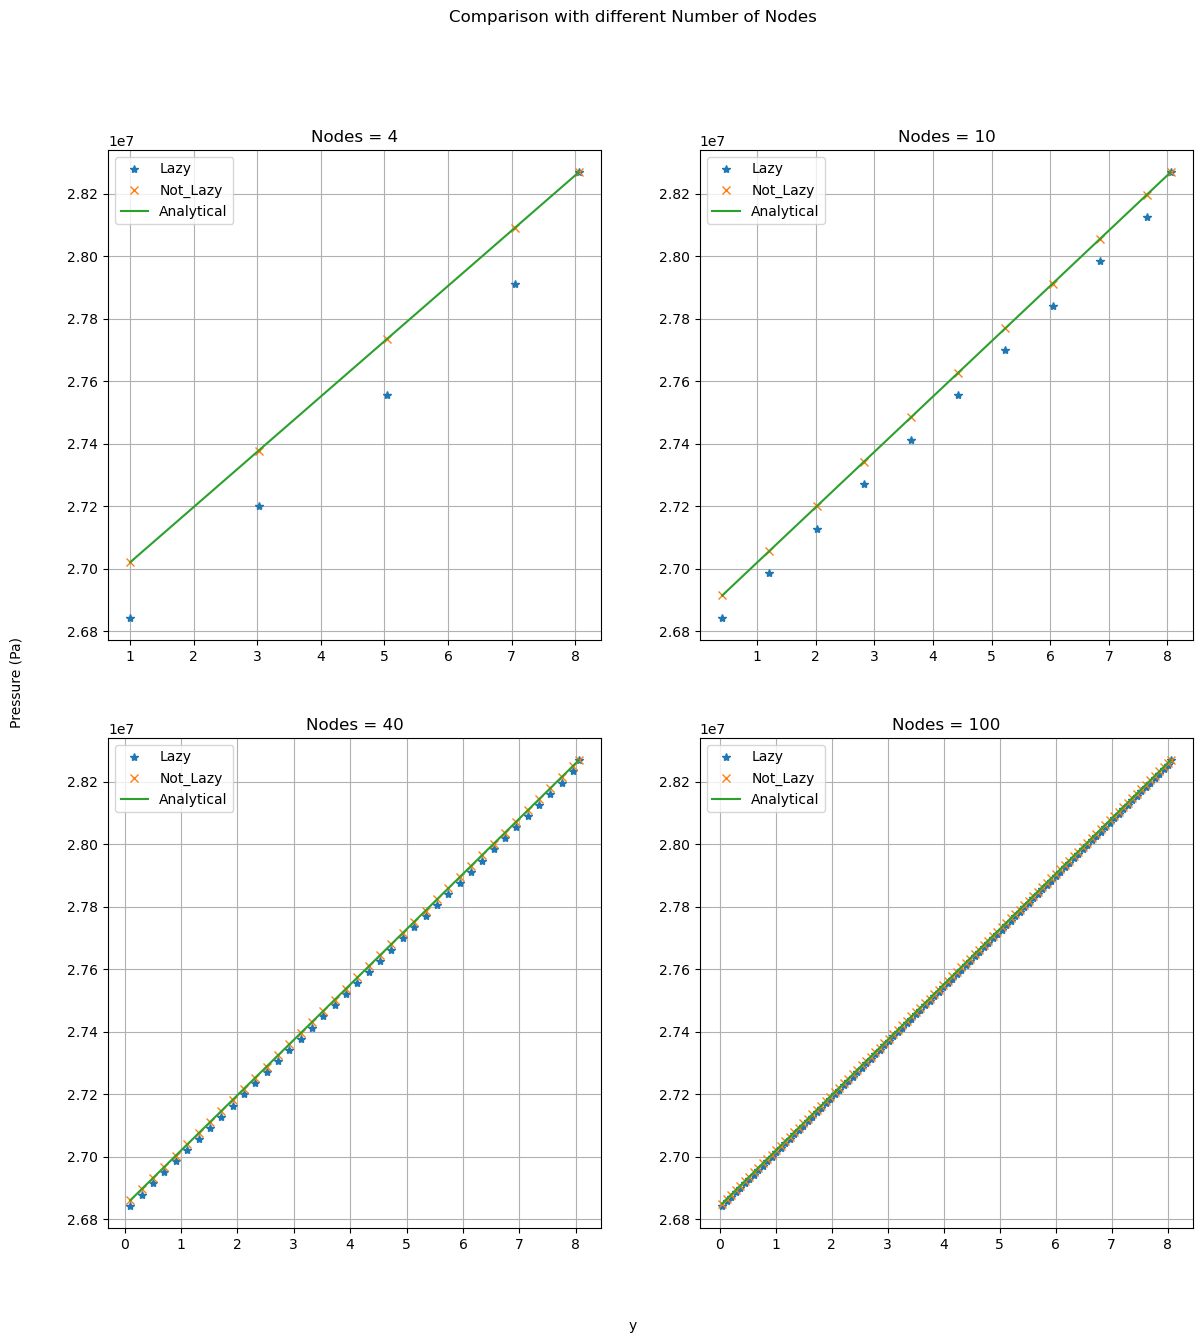

In [3]:
N = [4, 10, 40, 100]
fig, axs = plt.subplots(2,2, figsize = (14,14))
fig.suptitle('Comparison with different Number of Nodes')
fig.text(0.5, 0.04, 'y', ha='center', va='center')
fig.text(0.06, 0.5, 'Pressure (Pa)', ha='center', va='center', rotation='vertical')
# Making subplots for different step sizes
i = 0
while i < len(N):
    PS = PressureSolver(N[i], 0.01, 1)
    y, sol = PS.numerical_lazy()
    y1, sol1 = PS.numerical_notlazy()
    y2, sol2 = PS.analytical(0)
    l = 1 if i >=2 else 0
    m = 1 if i == 1 or i == 3 else 0
    axs[l, m].plot(y,sol, '*', label = 'Lazy')
    axs[l, m].plot(y1, sol1, 'x', label = 'Not_Lazy')
    axs[l, m].plot(y2, sol2, label = 'Analytical')
    axs[l, m].set_title('Nodes = {}'.format(N[i]))
    axs[l, m].legend()
    axs[l, m].grid()
    i+= 1

C:\Users\mussa\AppData\Local\Temp\ipykernel_20632\3410721238.py:85: RuntimeWarning: divide by zero encountered in scalar divide
  self.Xi = (self.eta*np.exp(-2*self.y)*self.dt)/((self.rw**2)*self.dy**2)


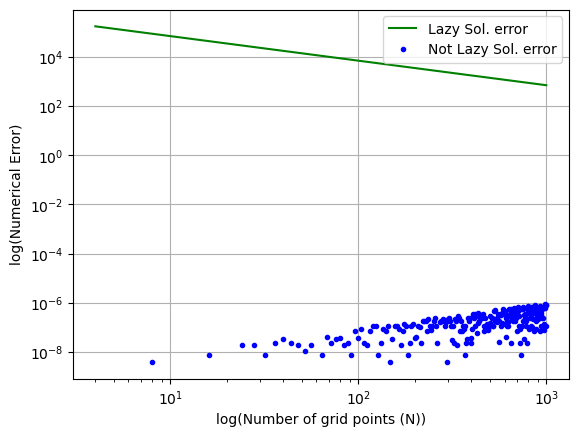

In [4]:
#Scatter plot for range of step sizes against numerical error
N = np.linspace(4,1000, 250)
PS = PressureSolver(N,0.01, 1)
PS.err()

### **Discussion:**

After solving therotically and logically, we can say that the numerical error scales as expected with respect to the grid size. We compared with different number of nodes. Changing the grid size with a factor of 10, reduces the numerical error with the same factor, for the Lazy numerical Method, as proved theoratically in part 4 of Excercise 1 that we have shown.

However for Not_Lazy method, the error is very low, but it can be seen that it increases as we increase the grid size which is shown in the graph.

## Exercise 2

### Part 1
<img src="exercises/2a.jpeg" width=500 height=auto auto="Exercise 2 Part 1">
<img src="exercises/2a2.jpeg" width=500 height=auto auto="Exercise 2 Part 1">
<img src="exercises/2a3.jpeg" width=500 height=auto auto="Exercise 2 Part 1">

### Part 2

In [5]:
PS2_2 = PressureSolver(4, 0.01, 10)
Matrix_A,_ = PS2_2.time_dep_mat('d')
print("Matrix A: \n", Matrix_A)

Matrix A: 
 [[ 5.28702460e+03 -5.28602460e+03  0.00000000e+00  0.00000000e+00]
 [-9.42633218e+01  1.89526644e+02 -9.42633218e+01  0.00000000e+00]
 [ 0.00000000e+00 -1.68095582e+00  4.36191165e+00 -1.68095582e+00]
 [ 0.00000000e+00  0.00000000e+00 -2.99757363e-02  1.08992721e+00]]


### Part 3

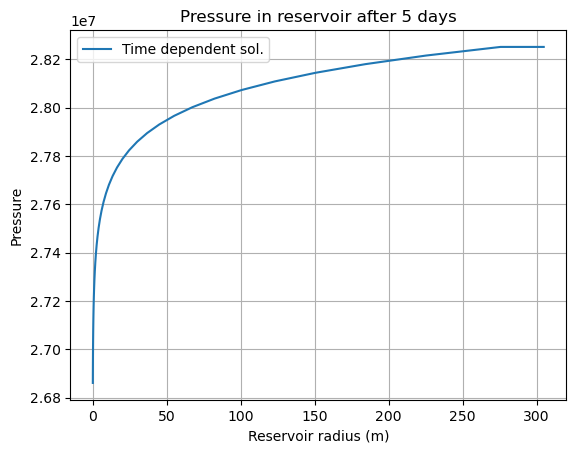

In [6]:
method = 's' #Using sparse matrix solver
Nodes = 40
total_time = 5 #time in days
PS2_3 = PressureSolver(Nodes, 0.01, total_time)
radius, pressure = PS2_3.time_solver(method)
PS2_3.plot_graph(radius, pressure, '-', 'Time dependent sol.', 'Reservoir radius (m)', 'Pressure', "Pressure in reservoir after {} days".format(total_time))

## Exercise 3: Accuracy and Performance of Time Dependent Solution

### Part 1

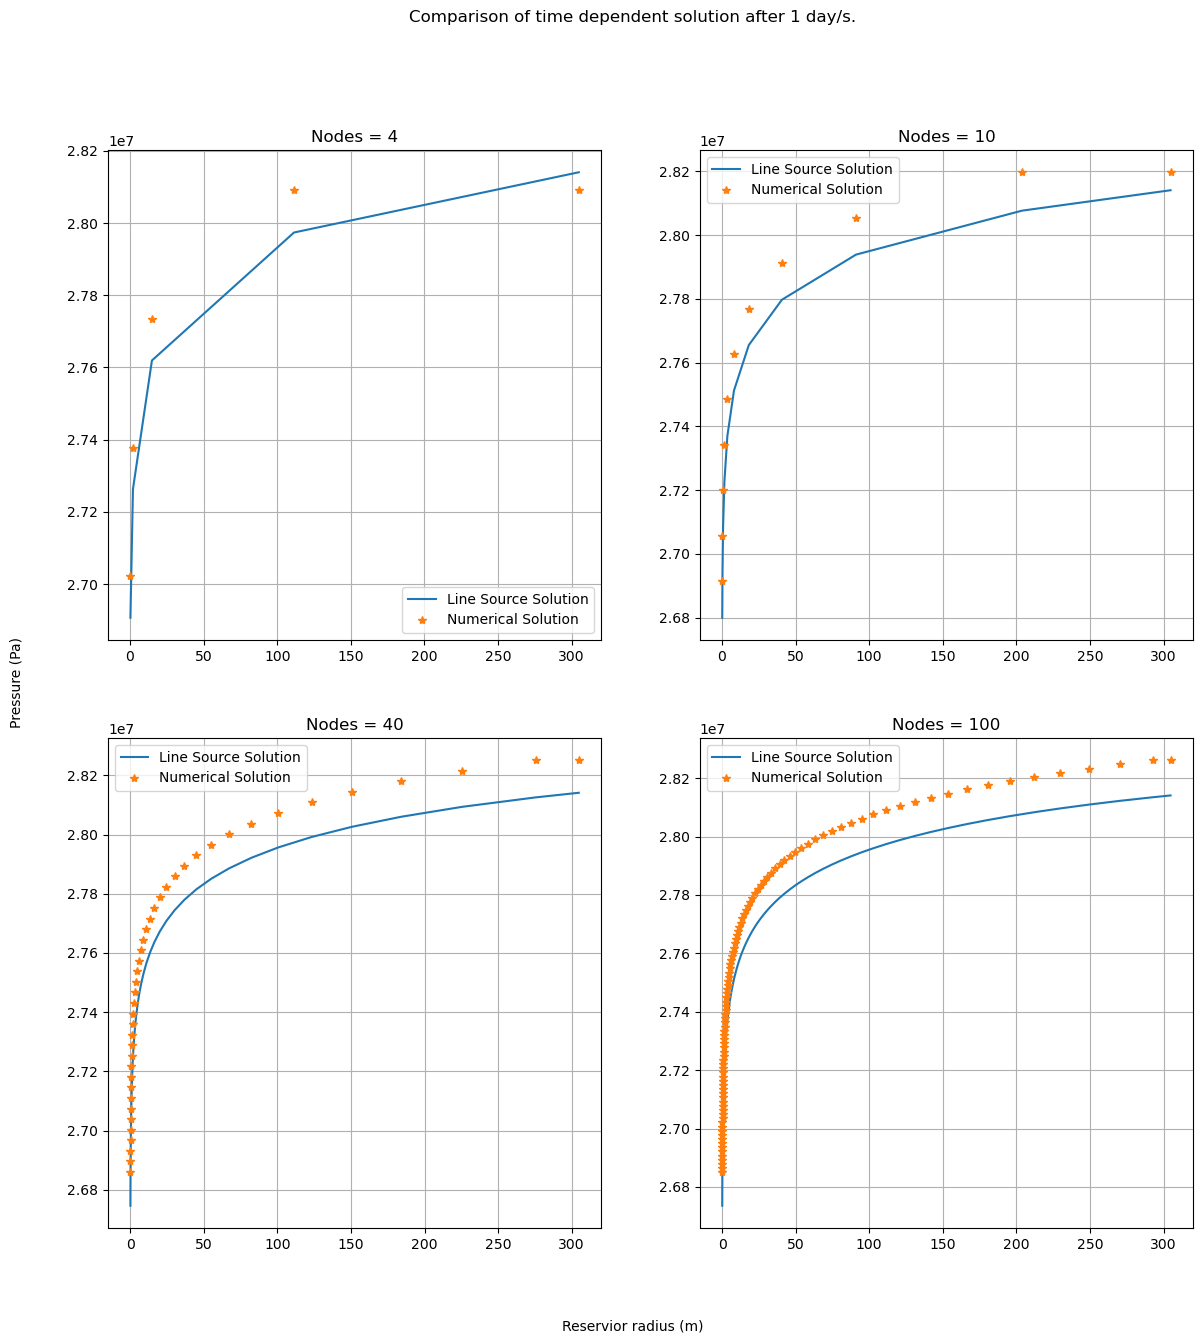

In [7]:
N = [4, 10, 40, 100]
method = 's'
total_time = 1
fig, axs = plt.subplots(2,2, figsize = (14,14))
fig.suptitle('Comparison of time dependent solution after {} day/s.'.format(total_time))
fig.text(0.5, 0.04, 'Reservior radius (m)', ha='center', va='center')
fig.text(0.06, 0.5, 'Pressure (Pa)', ha='center', va='center', rotation='vertical')
i = 0
# Making subplots for different step sizes and comparing results with line source solution
while i < len(N):
    PS3_1 = PressureSolver(N[i], 0.01, total_time)
    r, p = PS3_1.line_source()
    r1, p1 = PS3_1.time_solver(method)
    l = 1 if i >=2 else 0
    m = 1 if i == 1 or i == 3 else 0
    axs[l, m].plot(r,p, '-', label = 'Line Source Solution')
    axs[l, m].plot(r1, p1, '*', label = 'Numerical Solution')
    axs[l, m].set_title('Nodes = {}'.format(N[i]))
    axs[l, m].legend()
    axs[l, m].grid()
    i+= 1


#### **Discussion**

When comparing the numerical solution with the line source solution the error reduces by increasing the number of grid points. However, a more notable point was that the total duration also effects the error between the line source and numerical solution, substantially. 

Another observation was that the error increases as we go from the start of the reservoir to the end, for each node size.

### Part 2

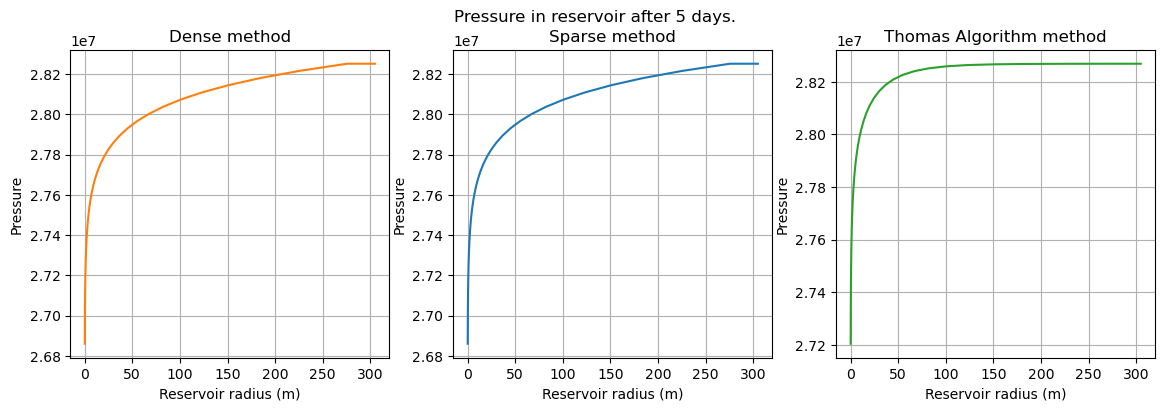

In [8]:

#Input the solver matrix method (dense, sparse and Thomas Algorithm )
#To solve for given solver method

methods = ["d", "s", "t"]
method_names =["Dense", "Sparse", "Thomas Algorithm"]
colors = ["orange", "blue", "green"]
Nodes = 40
total_time = 5
PS3_2 = PressureSolver(Nodes, 0.01, total_time)


# Graph
fig, axs = plt.subplots(1,3, figsize = (14,4))
fig.suptitle("Pressure in reservoir after {} days.".format(total_time))
fig.add_gridspec()

for ax, method, method_name, color in zip(axs, methods, method_names, colors):
    radius, pressure = PS3_2.time_solver(method)
    ax.set_title(f"{method_name} method")
    ax.plot(radius, pressure, f'tab:{color}')
    ax.grid()
    ax.set_xlabel("Reservoir radius (m)")
    ax.set_ylabel("Pressure")

#radius, pressure = PS3_2.time_solver(method)
#m = 'Dense' if method == 'd' else 'Sparse' if method == 's' else 'Thomas_alg'

#PS3_2.plot_graph(radius, pressure, '-', 'Time dependent sol.', 'Reservoir radius (m)', 'Pressure', "Pressure in reservoir after {} days, with {} method.".format(total_time, m))

In [9]:
# Solving with different matrix solver methods, to find time for each solver:
m1 = 'd'
m2 = 's'
m3 = 't'
Nodes = 50
total_time = 10
PS3_2_2 = PressureSolver(Nodes, 0.01, total_time)
print("Time to solve with dense matrix for {} nodes and after {} days is: ".format(Nodes, total_time))
%timeit PS3_2_2.time_solver(m1)
print("\n","Time to solve with sparse matrix for {} nodes and after {} days is: ".format(Nodes, total_time))
%timeit PS3_2_2.time_solver(m2)
print("\n", "Time to solve with thomas algorithm for {} nodes and after {} days is: ".format(Nodes, total_time))
%timeit PS3_2_2.time_solver(m3)

Time to solve with dense matrix for 50 nodes and after 10 days is: 
102 ms ± 8.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

 Time to solve with sparse matrix for 50 nodes and after 10 days is: 
480 ms ± 56.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

 Time to solve with thomas algorithm for 50 nodes and after 10 days is: 
226 µs ± 21.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


#### **Discussion**:
The dense matrix is the slowest and the thomas algorithm is the fastest matrix solver method.
These results are noticeable if the node size is 50 or greater

## Exercise 4

### Part 1
<img src="exercises/4a.jpeg" width=500 height=auto auto="Exercise 4 Part 1">

### Part 2

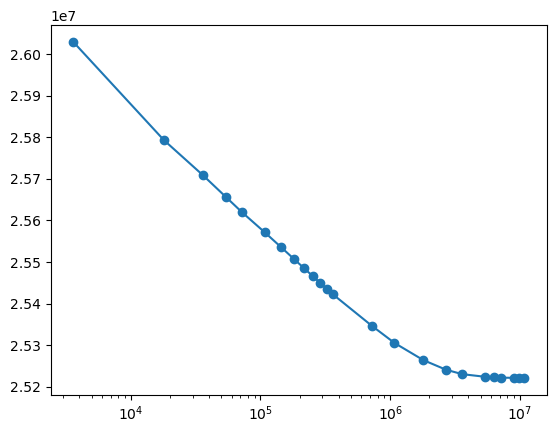

In [10]:
#Plotting experimental well data

PS4_2 = PressureSolver(4, 0.01, 1)
wd = PS4_2.read_well_data()
plt.plot(wd["time"],wd["well_pressure"],'o-')
plt.xscale('log')

### Part 3

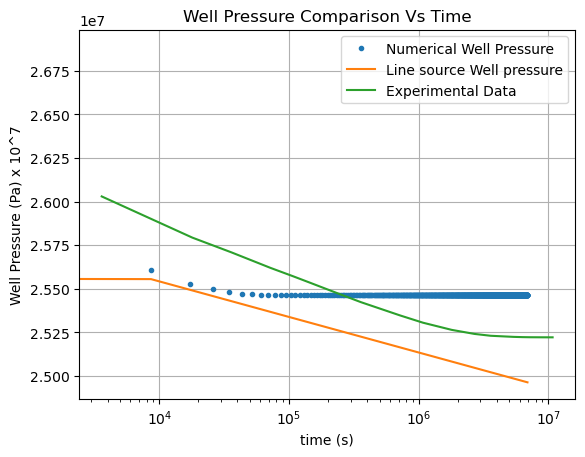

In [13]:
## initial values of pi, re and k
method = 's'
Nodes = 400
total_time = 80
PS4_3 = PressureSolver(Nodes, 0.1, total_time, pi = 3900, k= 500, re= 1000)
time, pressure, l_pressure= PS4_3.well_pressure()
PS4_3.plot_graph(time, pressure, styl= '.', lbl= "Numerical Well Pressure")
PS4_3.plot_graph(time, l_pressure, lbl= "Line source Well pressure")
PS4_3.plot_graph(wd["time"],wd["well_pressure"], lbl= "Experimental Data", xlabel= 'time (s)', ylabel= 'Well Pressure (Pa) x 10^7', title= 'Well Pressure Comparison Vs Time')
plt.xscale('log')

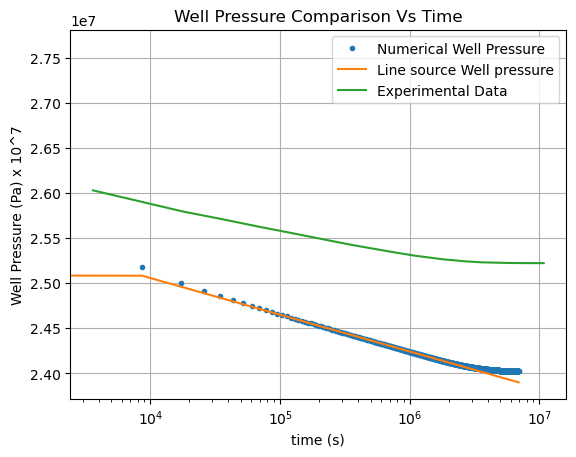

In [14]:
# After iterations the values of pi, k and re were found to be as shown
PS4_3 = PressureSolver(Nodes, 0.1, total_time, pi = 4007, k= 250, re= 8500)
time, pressure, l_pressure= PS4_3.well_pressure()
PS4_3.plot_graph(time, pressure, styl= '.', lbl= "Numerical Well Pressure")
PS4_3.plot_graph(time, l_pressure, lbl= "Line source Well pressure")
PS4_3.plot_graph(wd["time"],wd["well_pressure"], lbl= "Experimental Data", xlabel= 'time (s)', ylabel= 'Well Pressure (Pa) x 10^7', title= 'Well Pressure Comparison Vs Time')
plt.xscale('log')

#### **Discussion**:

Here, while doing the iterative process various combinations of k, re and pi result in a solution close to experimental data. However, the values we chose were the ones that closely replicated the effect of well pressure getting constant at the end which is more convenient for the project.

In [16]:
c = PS4_3.curve_fit()
print(c)

[-4.94056806e+00  9.41841446e-15]


### Part 4

In [17]:
Volume, radius = PS4_3.Volume_of_water()
print('Volume of water based for the reservoir of radius {}m is: {}m^3'.format(radius, Volume))

Volume of water based for the reservoir of radius 2590.8m is: 17675239.448891815m^3


## Reflections

### How did we work?
Basically, we worked on project in the group room, alongside with the lab classes which helped us a lot to discuss about the problems as well as finding the solution. We worked together even if any of us find any solution then we discussed about this and then came to a proper solution which looked like a good way of learning for us. Before finalizing any problem's solution, we together ended up with a good solution and agreed upon that.

Jason created some initial coding and worked on finding the solutions to the problem in theoretical matter. Taz and Tapas worked also on the theorectical matter proofs final Python code. Mussa wrote large sections of Python code and acted as Project Manager by compiling the individual contributions into a final product.


### What we did in the project?
We evaluated the analtical, numerical and line-source solution with two different boundary conditions and also found out the error between them by visuallizing the graphs. Then we matched our well test data from the provided file.

### Our Learnings?
We learnt the implementation of different numerical solvers for the radial deffusivity equation. We also learnt about PressureSolver Class. Besides, we also came across the learning of using two different boundary conditions. Although we did struggle in some stages but this project will help us in near future.future.


## Conclusion

<!-- a simple model is better than complex model-->
We introduced 'class PressureSolver:' which helped us to write the clear and not repeating code which helps us to avoid unavoidable and unwanted errors. With radial differential equation we found out the analytical and numerical solution with Lazy and Not- Lazy bountary conditions, and we concluded that 'not so Lazy' numerical solution is more close to the analytical solution (True Solution) than the 'Lazy' numerical solution.  For time dependence solution, as we increases the time, the difference between line-sourse solution and numerical solution gets larger and vise versa.

The sparse and dense method both gave the same results with a small numerical error. Both of these methods provided a numerical solution similar to the analytical line source solution. For considerale number of nodes, we noticed that, Thomas algorithm takes lesser time as compared to Spare and dense to calculate the numerical solution. 
In conclusion, this project represents a crucial step toward understanding the potential of analysis in determining reservoir size which could be really interesting for further research.

A famous quote from George E. P. Box is "All models are wrong, but some are useful", and this project has proven that in many ways the most insightful model is the one built by yourself (or small group), since you then have the ability to incrementally expand the model's complexity as required to achieve greater accuracy, thereby expanding your own knowledge of the specific phenomena and about modeling in general.

## References

1) Aksel Hiorth. Computational Engineering and Modeling, 2021
   https://github.com/ahiorth/CompEngineering
2) Amin Nemati, Introduction to Well Testing
    https://www.academia.edu/43686719/Introduction_to_well_testing_Analysis_By_Amin_Nematizadeh_Haghighi
3) Drilling Engineering, 2021
    https://www.sciencedirect.com/topics/engineering/diffusivity-equation
4) Patel, Mahesh Chandra, and Aaditya Singh. "Near Wellbore Damage and Types of Skin Depending on Mechanism of Damage.", 2016
    https://onepetro.org/SPEFD/proceedings-abstract/16FD/1-16FD/D012S007R008/187006